<a href="https://colab.research.google.com/github/Cesare-Caputo/PyPSA-gridtracer/blob/main/pypsa_gridtracer_from_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#setup

In [ ]:
!pip install osgeo
!pip install geopandas rtree
!pip install rasterio
!pip install pyyaml==5.1
# !pip uninstall torch
# !pip uninstall detectron2
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html

  ERROR: Failed building wheel for osgeo
  Running setup.py clean for osgeo
Failed to build osgeo
    Running setup.py install for osgeo ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-9hrjbynr/osgeo_e83d247d9ab94aba843513cd14341268/setup.py'"'"'; __file__='"'"'/tmp/pip-install-9hrjbynr/osgeo_e83d247d9ab94aba843513cd14341268/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-iyz2p5mv/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/osgeo Check the logs for full command output.
     |████████████████████████████████| 1.0 MB 8.4 MB/s 
     |██████████████████████████

#utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import helper
import os
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.engine import DefaultPredictor


def load_model(model_path, threshold=0.3):
    '''
    Loads detectron2 model, returns model of type torch.nn.Module

    Parameters
    ----------
    model_path : str
        path to .pth file of model
    threshold : float \in [0,1]
        detection threshold for model

    Returns
    ----------
    predictor : detectron2.model
    '''
    frcnn= 'faster_rcnn_R_101_FPN_3x.yaml'

    cfg = get_cfg() # Model Config
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/"+frcnn))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold  # for R-CNN Models
    cfg.INPUT.FORMAT = "RGB"

    # model_name = '2021-11-28_frcnn_200000_dukeset/model_final.pth'
    # model_path = '/content/drive/MyDrive/PyPSA_Africa_images/models/'+model_name

    model = build_model(cfg)

    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(model_path)

    predictor = DefaultPredictor(cfg)
    transforms = predictor.aug

    return model, transforms

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


def get_true_images(dir, num, show=False):
    '''
    loads a list of images that all have a tower in them. dir has to be a directory
    only containing such images

    Parameters
    ----------
    dir : str
        directory of true examples
    num : int
        length of list returned
    show : bool
        if True, some of the examples are shown

    Returns
    ----------
    imgs : list of 3 x height x width np.ndarray
        list of obtained images
    '''

    imgs = os.listdir(dir)
    imgs = [os.path.join(dir, img) for img in imgs]
    # randomize order
    np.random.shuffle(imgs)

    imgs = [cv2.imread(img) for img in imgs[:num]]

    if show:
        print('here are 10 images we have obtained')
        for img in imgs[:10]:
            _, ax = plt.subplots(1, 1, figsize=(4, 4))
            ax.imshow(img)
            plt.show()

    return imgs

#build predictor and retrieve model

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import helper
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

#from image_utils import get_true_images

def build_predictor_model(threshold=0.2, model_path=None):
    '''
    Returns predictor and model using detectron2 from files stored in the
    PyPSA Africa drive

    Parameters
    ----------
    threshold : float
        detection threshold
    model_path : str
        path to .pth file

    Returns
    ---------
    predictor : detectron2.DefaultPredictor
    model : torch.nn.Module

    '''

    print('Building predictor from path:')
    print(model_path)

    ds_path = f'/content/drive/My Drive/PyPSA_Africa_images/datasets/duke_train/data/'
    json_path = f'/content/drive/My Drive/PyPSA_Africa_images/datasets/duke_train/labels.json'
    ds_name = 'duke'

    if ds_name in DatasetCatalog.list():
        DatasetCatalog.remove(ds_name)
        MetadataCatalog.remove(ds_name)

    register_coco_instances(ds_name, {}, json_path, ds_path)

    frcnn = 'faster_rcnn_R_101_FPN_3x.yaml'

    cfg = get_cfg() # Model Config
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/"+frcnn))

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    if model_path is None:
        model_path = os.path.join('/content', 'drive', 'MyDrive', 'PyPSA_Africa_images', 'models',
                                    '2021-11-29_frcnn_180000_dukeset', 'model_final.pth')

    cfg.MODEL.WEIGHTS = model_path

    print('working with path: ', model_path)
    cfg.INPUT.FORMAT = 'BGR'

    predictor = DefaultPredictor(cfg)
    model = build_model(cfg)

    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(model_path)

    return predictor, model


def eval_predictor(imgs, model_path=None, threshold=0.1):
    '''
    Method to check performance of model on some imgs (only chekc via plotting, does
    not return precision scores)

    Parameters
    ----------
    imgs : list of np.array
        images on which inference will run
    model_path : str
        path to model .pth file
    threshold : float
        cutoff for what is considered as an instance

    Returns
    ----------
    -

    '''

    print('Evaluating model stored under:')
    print(model_path)

    predictor, model = build_predictor_model(threshold=threshold, model_path=model_path)
    model.eval()

    for img in imgs:

        out = predictor(img)
        # out = predictor(img[:,:,::-1])
        v = Visualizer(img, MetadataCatalog.get('duke'), scale=1.5)
        out = v.draw_instance_predictions(out["instances"].to("cpu"))
        cv2_imshow(out.get_image())

        with torch.no_grad():

            img = predictor.aug.get_transform(img).apply_image(img)
            img = torch.as_tensor(img.astype('float32').transpose(2, 0, 1))
            x = [{'image': img, 'width': 256, 'height': 256}]
            pred = predictor.model(x)
            print(pred)

if __name__ == '__main__':

    duke_img_dir = '/content/drive/MyDrive/PyPSA_Africa_images/datasets/duke_val/data/'
    duke_imgs = get_true_images(duke_img_dir, 5)

    model_path = '/content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth'
    #model_path_cycle = '/content/drive/MyDrive/PyPSA_Africa_images/PISA_models/11_01_2022_fake_maxar_train/model_final.pth'

    #print('The cycle GAN trained model')
   # eval_predictor(duke_imgs, model_path=model_path_cycle)

    print('The regular trained model')
    eval_predictor(duke_imgs, model_path=model_path)

In [ ]:
import torch
from shapely import geometry

### note that this also appends scores as compared to earlier version
def eval_instances2(instances, ul, towers, fn, upper_left, pixel_size):
    '''
    Stores the centers of all obtained instances in a dataframe

    Parameters
    ----------
    instances : detectron2.Instances
        instances obtained from a single input image
    ul : np.ndarray
        numpy array of upper left coordinates
    towers : geopandas.GeoDataFrame
        geodataframe of instances already obtained (towers are point geometries)
    fn : str
        filename of tif currently being investigated
    upper_left, pixel_size :
        numpy arrays to transform to coordinates

    Returns
    ----------
    towers : geopandas.GeoDataFrame
        updated geodataframe
    '''

    #boxes = instances['instances'].get('pred_boxes').tensor
    #boxes = boxes.resize_(boxes.size()[0], 2, 2)


    #scores = instances['instances'].get('scores').to('cpu').numpy().item()
    #scores = instances['instances'].get('scores').to('cpu').numpy()

    instance_predictions = zip(
        instances['instances'].get('pred_boxes'),
        instances['instances'].get('scores'))

    predictions = []
    for box, score in instance_predictions:

        pixels = (torch.tensor(ul) + box.mean(dim=0).to('cpu')).numpy()
        coords = upper_left + pixel_size * pixels
        point = geometry.Point(coords)
        #towers = towers.append({'tif': fn, 'geometry': point, 'score': scores}, ignore_index=True)
        towers = towers.append({'tif': fn, 'geometry': point, 'score': score.item()}, ignore_index=True)

    return towers

#infer tower geodf

##small batch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import os
import torch
from osgeo import gdal
from shapely import geometry
from torchvision import transforms
from tqdm import tqdm


def infer_towers(in_dir,
                 tifs,
                 out_dir,
                 predictor,
                 width=256,
                 height=256,
                 batch_size=100,
                 stop=10,
                 folium=False,
                 add_true=None,
                 seed=None,
                 reverse=False,
                 plot_batch=False
                 ):
    '''
    Iterate over tif files and runs batch-wise inference using model. Resulting hits are stored
    in a GeoDataFrame as shapely.geometries.Point . Returns a folium map if desired


    Parameters
    ----------
    in_dir : str
        directory where the tif files can be found
    tifs : list of str
        images in tif format that should be stored
    out_dir : str
        directory where resulting .png files should be stored
    model : torch.nn.Module
        torch model to detect transmission and distribution towers
    width : int
        number of pixels on the x-axis
    height : int
        number of pixels on the y-axis
    batch_size : int
        number of examples in each model forward pass
    stop : int
        algorithms stops execution after that number of iterations
    folium : bool
        makes the function return a folium.Map object with tif shape and found towers
    add_true : None or str
        if str, some images from that dir containing towers are replacing half of the images in each batch
    seed : int
        seed to all random operations
    reverse : bool
        if True, goes over the tif from bottom to top
    plot_batch : bool
        if True, plots the images in every batch

    Returns
    ----------
    towers : geopandas.GeoDataFrame
        dataframe of towers with columns: fn (filename of tif), geometry (shapely point geometries of towers)
    tifs : geopandas.GeoDataFrame
        dataframe of tif Polygons
    (optional) m : folium.Map
        map with all datapoints from both dataframes

    '''

    np.random.seed(seed)

    # set up dataframe to store geometries of investigated tif files
    tif_df = gpd.GeoDataFrame(columns=["filename", "geometry"]).set_crs(epsg=4326)
    # list of towers that are found in tifs
    towers_df = gpd.GeoDataFrame(columns=['tif', 'geometry', 'score']).set_crs(epsg=4326)

    if not isinstance(tifs, list):
        assert isinstance(tifs, str), f'Pass list of tif filenames, instead of {tifs}'
        tifs = [tifs]

    tifs = [os.path.join(in_dir, tif) for tif in tifs]

    for fn in tifs:

        print(f'Looking at imagery in {fn}!')

        # open files
        ds = gdal.Open(fn)
        info = gdal.Info(fn, format="json")
        bands = [ds.GetRasterBand(i) for i in range(1, 4)]

        # extract relevant geographical data
        transform = info["geoTransform"]
        upper_left = np.array([transform[0], transform[3]])
        pixel_size = np.array([transform[1], transform[5]])

        tif_width = info['size'][0]
        tif_height = info['size'][1]

        # append tif extent to dataframe
        tif_geom = geometry.Polygon([info['cornerCoordinates']['upperLeft'],
                                     info['cornerCoordinates']['lowerLeft'],
                                     info['cornerCoordinates']['lowerRight'],
                                     info['cornerCoordinates']['upperRight']])

        tif_df = tif_df.append({'filename': fn, 'geometry': tif_geom}, ignore_index=True)

        print('obtained transform: ', transform)
        print('ul: ', upper_left)
        print('pixelz: ', pixel_size)

        print('info: ', info['size'])

        num_cols = tif_width // width
        num_rows = tif_height // height

        num_batches = (num_cols * num_rows) // batch_size

        print('pngs per row {}'.format(num_cols))
        print('pngs per col {}'.format(num_rows))

        print('batch size: ', batch_size)

        # count detected instances
        instance_count = 0
        batch_count = 0

        for batch in tqdm(range(min([num_batches, stop]))):

            batch_count += 1

            if reverse:
                batch = num_batches - 1 - batch

            full_batch = np.zeros((height, 0, 3))

            # create a dataframe to connect detections to coordinates
            batch_df = pd.DataFrame(columns=['img_ul_x', 'img_ul_y'])

            start_png = batch * batch_size
            end_png = (1+batch) * batch_size

            start_col = start_png % num_cols
            end_col = end_png % num_cols

            start_row = start_png // num_cols
            end_row = end_png // num_cols

            # Go over rows contained in current batch
            for row in range(start_row, end_row+1):

                # obtain x coordinates of interest
                if row == start_row:
                    start_pixel_x = width * start_col
                else:
                    start_pixel_x = 0.

                if row == end_row:
                    end_pixel_x = width * end_col
                else:
                    end_pixel_x = width * num_cols

                row_width = int(end_pixel_x - start_pixel_x)
                start_pixel_y = row * height

                # Assign upper left corner pixel coordinates to batch_df
                img_ul_x = np.arange(start_pixel_x, end_pixel_x, width)
                img_ul_y = np.ones(row_width//width) * height * row

                appendix = pd.DataFrame({'img_ul_x': img_ul_x, 'img_ul_y': img_ul_y})
                batch_df = batch_df.append(appendix, ignore_index=True)

                row_pixels = np.ones((height, row_width, 3))
                # obtain the three bands
                for i in range(3):
                    row_pixels[:,:,i] = bands[i].ReadAsArray(start_pixel_x, start_pixel_y, row_width, height)

                full_batch = np.hstack([full_batch, row_pixels])

            # full_batch = full_batch[:, :, ::-1]

            # full_batch = torch.tensor(full_batch)
            full_batch = np.split(full_batch, full_batch.shape[1]//width, axis=1)
            #full_batch = torch.split(full_batch, [width for _ in range(batch_size)], dim=1)

            # print('initial shape')
            #print(len(full_batch))
            #for ex in full_batch:
            #     print(ex.shape)
            # return

            full_batch = [{'image': img, 'height': height, 'width': width} for img in full_batch]

            # for testing purposes: add images that have towers in them
            if add_true is not None:
                true_imgs = get_true_images(add_true, len(full_batch) // 2)
                for i, _ in enumerate(full_batch):
                    if i % 2 == 0:
                        full_batch[i]['image'] = true_imgs[i//2][:, :, ::-1]

            if plot_batch:
                print('resulting batch after adding hits')
                plot_width = 20
                fig, axs = plt.subplots(1, len(full_batch), figsize=(plot_width, plot_width/len(full_batch)))
                for ax, img in zip(axs, full_batch):
                    ax.imshow(img['image'] / 255)
                plt.show()

            for i, img in enumerate(full_batch):

                curr_img = img['image'].astype(np.uint8)

                # _, ax = plt.subplots(1, 1, figsize=(4,4))
                # ax.imshow(curr_img)
                # plt.show()

                # print(type(curr_img))
                # print('before trafo')
                # print(curr_img.shape)
                curr_img = predictor.aug.get_transform(curr_img).apply_image(curr_img)
                curr_img = torch.as_tensor(curr_img.astype('float32').transpose(2, 0, 1))
                # print('after trafo')
                # print(curr_img.size())
                img['image'] = curr_img
                full_batch[i] = img

            # print('Investigate full batch shape')

            '''
            print('len: ', len(full_batch))
            shape = full_batch[0]['image'].size()
            print('shape of first examples: ')
            print(shape)
            for i, ex in enumerate(full_batch):
                if not shape == ex['image'].size():
                    curr_shape = ex['image'].size()
                    print(f'deviation in example {i}: {curr_shape}')
            '''


            with torch.no_grad():
                pred = predictor.model(full_batch)

            for pre, (i, row) in zip(pred, batch_df.iterrows()):

                if len(pre['instances']) > 0:
                    towers_df = eval_instances2(pre, np.array([row['img_ul_x'], row['img_ul_y']]),
                                            towers_df, fn, upper_left, pixel_size)

            if batch_count == stop: break

        print('resulting towers')
        print(towers_df.head())
        print(towers_df.tail())

    if folium:
        import folium

        m = folium.Map(location=info['cornerCoordinates']['center'][::-1])

        for i, point in towers_df.geometry.iteritems():
            folium.Marker([point.coords.xy[1][0], point.coords.xy[0][0]], popup=f"Tower {i}").add_to(m)

        tifs_json = tif_df.to_json()
        tifs_json = folium.GeoJson(data=tifs_json,
                        style_function=lambda x: {'fillColor': 'orange'})
        tifs_json.add_to(m)

        return towers_df, tif_df, m

    else:
        return towers_df, tif_df


if __name__ == '__main__':

    # model_path = os.path.join('/content', 'drive', 'MyDrive', 'PyPSA_Africa_images', 'models',
    #                             '2021-11-29_frcnn_180000_dukeset', 'model_final.pth')

    model_path = '/content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth'
    # model_path = '/content/drive/MyDrive/PyPSA_Africa_images/PISA_models/11_01_2022_fake_maxar_train/model_final.pth'
    detection_thresh = 0.05
    # predictor = load_predictor(model_path, threshold=detection_thresh)
    predictor, _ = build_predictor_model(threshold=detection_thresh, model_path=model_path)
    del _

    #eval_predictor(duke_imgs[:5], model_path=model_path)

    # true_dir = '/content/drive/MyDrive/PyPSA_Africa_images/datasets/maxar_train/data'
    true_dir = None

    base_dir = '/content/drive/My Drive/PyPSA_Africa_images'
    tif_names = ['10500100103B0300.tif']
    in_dir = os.path.join(base_dir, 'maxar/ghana/raw')
    out_dir = None

    seed = 1
    towers, tifs, m = infer_towers(in_dir, tif_names, out_dir, predictor,
                             stop=10, batch_size=5, folium=True, add_true=true_dir, seed=seed, reverse=False,
                             plot_batch=False)



Building predictor from path:
/content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth
working with path:  /content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth
Looking at imagery in /content/drive/My Drive/PyPSA_Africa_images/maxar/ghana/raw/10500100103B0300.tif!
obtained transform:  [-2.177094300568735, 4.4493556022e-06, 0.0, 9.012619798895205, 0.0, -4.4493556022e-06]
ul:  [-2.1770943  9.0126198]
pixelz:  [ 4.4493556e-06 -4.4493556e-06]
info:  [41624, 231295]
pngs per row 162
pngs per col 903
batch size:  5


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/li

resulting towers
                                                 tif  \
0  /content/drive/My Drive/PyPSA_Africa_images/ma...   
1  /content/drive/My Drive/PyPSA_Africa_images/ma...   
2  /content/drive/My Drive/PyPSA_Africa_images/ma...   
3  /content/drive/My Drive/PyPSA_Africa_images/ma...   
4  /content/drive/My Drive/PyPSA_Africa_images/ma...   

                   geometry     score  
0  POINT (-2.17647 9.01199)  0.691319  
1  POINT (-2.17655 9.01207)  0.454074  
2  POINT (-2.13858 9.01169)  0.772519  
3  POINT (-2.13858 9.01169)  0.402426  
4  POINT (-2.12780 9.01230)  0.986270  
                                                 tif  \
0  /content/drive/My Drive/PyPSA_Africa_images/ma...   
1  /content/drive/My Drive/PyPSA_Africa_images/ma...   
2  /content/drive/My Drive/PyPSA_Africa_images/ma...   
3  /content/drive/My Drive/PyPSA_Africa_images/ma...   
4  /content/drive/My Drive/PyPSA_Africa_images/ma...   

                   geometry     score  
0  POINT (-2.17647 9.01199)  

In [ ]:
len(towers)

5

(-2.2, -2.1)

<Figure size 864x720 with 0 Axes>

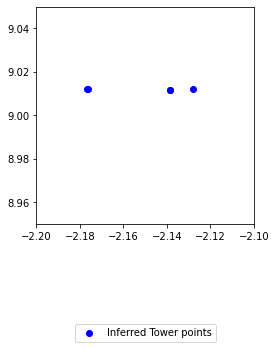

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = towers.plot( color = 'blue', label = 'Inferred Tower points')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -.5))
ax.set_ylim(8.95, 9.05)
ax.set_xlim(-2.2, -2.1)

##medium batch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import os
import torch
from osgeo import gdal
from shapely import geometry
from torchvision import transforms
from tqdm import tqdm


def infer_towers(in_dir,
                 tifs,
                 out_dir,
                 predictor,
                 width=256,
                 height=256,
                 batch_size=100,
                 stop=10,
                 folium=False,
                 add_true=None,
                 seed=None,
                 reverse=False,
                 plot_batch=False
                 ):
    '''
    Iterate over tif files and runs batch-wise inference using model. Resulting hits are stored
    in a GeoDataFrame as shapely.geometries.Point . Returns a folium map if desired


    Parameters
    ----------
    in_dir : str
        directory where the tif files can be found
    tifs : list of str
        images in tif format that should be stored
    out_dir : str
        directory where resulting .png files should be stored
    model : torch.nn.Module
        torch model to detect transmission and distribution towers
    width : int
        number of pixels on the x-axis
    height : int
        number of pixels on the y-axis
    batch_size : int
        number of examples in each model forward pass
    stop : int
        algorithms stops execution after that number of iterations
    folium : bool
        makes the function return a folium.Map object with tif shape and found towers
    add_true : None or str
        if str, some images from that dir containing towers are replacing half of the images in each batch
    seed : int
        seed to all random operations
    reverse : bool
        if True, goes over the tif from bottom to top
    plot_batch : bool
        if True, plots the images in every batch

    Returns
    ----------
    towers : geopandas.GeoDataFrame
        dataframe of towers with columns: fn (filename of tif), geometry (shapely point geometries of towers)
    tifs : geopandas.GeoDataFrame
        dataframe of tif Polygons
    (optional) m : folium.Map
        map with all datapoints from both dataframes

    '''

    np.random.seed(seed)

    # set up dataframe to store geometries of investigated tif files
    tif_df = gpd.GeoDataFrame(columns=["filename", "geometry"]).set_crs(epsg=4326)
    # list of towers that are found in tifs
    towers_df = gpd.GeoDataFrame(columns=['tif', 'geometry', 'score']).set_crs(epsg=4326)

    if not isinstance(tifs, list):
        assert isinstance(tifs, str), f'Pass list of tif filenames, instead of {tifs}'
        tifs = [tifs]

    tifs = [os.path.join(in_dir, tif) for tif in tifs]

    for fn in tifs:

        print(f'Looking at imagery in {fn}!')

        # open files
        ds = gdal.Open(fn)
        info = gdal.Info(fn, format="json")
        bands = [ds.GetRasterBand(i) for i in range(1, 4)]

        # extract relevant geographical data
        transform = info["geoTransform"]
        upper_left = np.array([transform[0], transform[3]])
        pixel_size = np.array([transform[1], transform[5]])

        tif_width = info['size'][0]
        tif_height = info['size'][1]

        # append tif extent to dataframe
        tif_geom = geometry.Polygon([info['cornerCoordinates']['upperLeft'],
                                     info['cornerCoordinates']['lowerLeft'],
                                     info['cornerCoordinates']['lowerRight'],
                                     info['cornerCoordinates']['upperRight']])

        tif_df = tif_df.append({'filename': fn, 'geometry': tif_geom}, ignore_index=True)

        print('obtained transform: ', transform)
        print('ul: ', upper_left)
        print('pixelz: ', pixel_size)

        print('info: ', info['size'])

        num_cols = tif_width // width
        num_rows = tif_height // height

        num_batches = (num_cols * num_rows) // batch_size

        print('pngs per row {}'.format(num_cols))
        print('pngs per col {}'.format(num_rows))

        print('batch size: ', batch_size)

        # count detected instances
        instance_count = 0
        batch_count = 0

        for batch in tqdm(range(min([num_batches, stop]))):

            batch_count += 1

            if reverse:
                batch = num_batches - 1 - batch

            full_batch = np.zeros((height, 0, 3))

            # create a dataframe to connect detections to coordinates
            batch_df = pd.DataFrame(columns=['img_ul_x', 'img_ul_y'])

            start_png = batch * batch_size
            end_png = (1+batch) * batch_size

            start_col = start_png % num_cols
            end_col = end_png % num_cols

            start_row = start_png // num_cols
            end_row = end_png // num_cols

            # Go over rows contained in current batch
            for row in range(start_row, end_row+1):

                # obtain x coordinates of interest
                if row == start_row:
                    start_pixel_x = width * start_col
                else:
                    start_pixel_x = 0.

                if row == end_row:
                    end_pixel_x = width * end_col
                else:
                    end_pixel_x = width * num_cols

                row_width = int(end_pixel_x - start_pixel_x)
                start_pixel_y = row * height

                # Assign upper left corner pixel coordinates to batch_df
                img_ul_x = np.arange(start_pixel_x, end_pixel_x, width)
                img_ul_y = np.ones(row_width//width) * height * row

                appendix = pd.DataFrame({'img_ul_x': img_ul_x, 'img_ul_y': img_ul_y})
                batch_df = batch_df.append(appendix, ignore_index=True)

                row_pixels = np.ones((height, row_width, 3))
                # obtain the three bands
                for i in range(3):
                    row_pixels[:,:,i] = bands[i].ReadAsArray(start_pixel_x, start_pixel_y, row_width, height)

                full_batch = np.hstack([full_batch, row_pixels])

            # full_batch = full_batch[:, :, ::-1]

            # full_batch = torch.tensor(full_batch)
            full_batch = np.split(full_batch, full_batch.shape[1]//width, axis=1)
            #full_batch = torch.split(full_batch, [width for _ in range(batch_size)], dim=1)

            # print('initial shape')
            #print(len(full_batch))
            #for ex in full_batch:
            #     print(ex.shape)
            # return

            full_batch = [{'image': img, 'height': height, 'width': width} for img in full_batch]

            # for testing purposes: add images that have towers in them
            if add_true is not None:
                true_imgs = get_true_images(add_true, len(full_batch) // 2)
                for i, _ in enumerate(full_batch):
                    if i % 2 == 0:
                        full_batch[i]['image'] = true_imgs[i//2][:, :, ::-1]

            if plot_batch:
                print('resulting batch after adding hits')
                plot_width = 20
                fig, axs = plt.subplots(1, len(full_batch), figsize=(plot_width, plot_width/len(full_batch)))
                for ax, img in zip(axs, full_batch):
                    ax.imshow(img['image'] / 255)
                plt.show()

            for i, img in enumerate(full_batch):

                curr_img = img['image'].astype(np.uint8)

                # _, ax = plt.subplots(1, 1, figsize=(4,4))
                # ax.imshow(curr_img)
                # plt.show()

                # print(type(curr_img))
                # print('before trafo')
                # print(curr_img.shape)
                curr_img = predictor.aug.get_transform(curr_img).apply_image(curr_img)
                curr_img = torch.as_tensor(curr_img.astype('float32').transpose(2, 0, 1))
                # print('after trafo')
                # print(curr_img.size())
                img['image'] = curr_img
                full_batch[i] = img

            # print('Investigate full batch shape')

            '''
            print('len: ', len(full_batch))
            shape = full_batch[0]['image'].size()
            print('shape of first examples: ')
            print(shape)
            for i, ex in enumerate(full_batch):
                if not shape == ex['image'].size():
                    curr_shape = ex['image'].size()
                    print(f'deviation in example {i}: {curr_shape}')
            '''


            with torch.no_grad():
                pred = predictor.model(full_batch)

            for pre, (i, row) in zip(pred, batch_df.iterrows()):

                if len(pre['instances']) > 0:
                    towers_df = eval_instances2(pre, np.array([row['img_ul_x'], row['img_ul_y']]),
                                            towers_df, fn, upper_left, pixel_size)

            if batch_count == stop: break

        print('resulting towers')
        print(towers_df.head())
        print(towers_df.tail())

    if folium:
        import folium

        m = folium.Map(location=info['cornerCoordinates']['center'][::-1])

        for i, point in towers_df.geometry.iteritems():
            folium.Marker([point.coords.xy[1][0], point.coords.xy[0][0]], popup=f"Tower {i}").add_to(m)

        tifs_json = tif_df.to_json()
        tifs_json = folium.GeoJson(data=tifs_json,
                        style_function=lambda x: {'fillColor': 'orange'})
        tifs_json.add_to(m)

        return towers_df, tif_df, m

    else:
        return towers_df, tif_df


if __name__ == '__main__':

    # model_path = os.path.join('/content', 'drive', 'MyDrive', 'PyPSA_Africa_images', 'models',
    #                             '2021-11-29_frcnn_180000_dukeset', 'model_final.pth')

    model_path = '/content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth'
    # model_path = '/content/drive/MyDrive/PyPSA_Africa_images/PISA_models/11_01_2022_fake_maxar_train/model_final.pth'
    detection_thresh = 0.05
    # predictor = load_predictor(model_path, threshold=detection_thresh)
    predictor, _ = build_predictor_model(threshold=detection_thresh, model_path=model_path)
    del _

    #eval_predictor(duke_imgs[:5], model_path=model_path)

    # true_dir = '/content/drive/MyDrive/PyPSA_Africa_images/datasets/maxar_train/data'
    true_dir = None

    base_dir = '/content/drive/My Drive/PyPSA_Africa_images'
    tif_names = ['10500100103B0300.tif']
    in_dir = os.path.join(base_dir, 'maxar/ghana/raw')
    out_dir = None

    seed = 1
    towers2, tifs2, m2 = infer_towers(in_dir, tif_names, out_dir, predictor,
                             stop=100, batch_size=20, folium=True, add_true=true_dir, seed=seed, reverse=True,
                             plot_batch=False)


Building predictor from path:
/content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth
working with path:  /content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth
Looking at imagery in /content/drive/My Drive/PyPSA_Africa_images/maxar/ghana/raw/10500100103B0300.tif!
obtained transform:  [-2.177094300568735, 4.4493556022e-06, 0.0, 9.012619798895205, 0.0, -4.4493556022e-06]
ul:  [-2.1770943  9.0126198]
pixelz:  [ 4.4493556e-06 -4.4493556e-06]
info:  [41624, 231295]
pngs per row 162
pngs per col 903
batch size:  20


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
  7%|▋         | 7/100 [00:17<03:45,  2.43s/it]/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecat

resulting towers
                                                 tif  \
0  /content/drive/My Drive/PyPSA_Africa_images/ma...   
1  /content/drive/My Drive/PyPSA_Africa_images/ma...   
2  /content/drive/My Drive/PyPSA_Africa_images/ma...   
3  /content/drive/My Drive/PyPSA_Africa_images/ma...   
4  /content/drive/My Drive/PyPSA_Africa_images/ma...   

                   geometry     score  
0  POINT (-2.02162 7.98465)  0.507989  
1  POINT (-2.00573 7.98470)  0.776680  
2  POINT (-2.00573 7.98470)  0.154255  
3  POINT (-1.99673 7.98596)  0.922025  
4  POINT (-2.01503 7.98603)  0.256859  
                                                   tif  \
164  /content/drive/My Drive/PyPSA_Africa_images/ma...   
165  /content/drive/My Drive/PyPSA_Africa_images/ma...   
166  /content/drive/My Drive/PyPSA_Africa_images/ma...   
167  /content/drive/My Drive/PyPSA_Africa_images/ma...   
168  /content/drive/My Drive/PyPSA_Africa_images/ma...   

                     geometry     score  
164  POINT (-2.

(array([47., 17., 11., 10., 11.,  8.,  4.,  5., 11., 45.]),
 array([0.0502356 , 0.14520888, 0.24018216, 0.33515544, 0.43012873,
        0.52510201, 0.62007529, 0.71504857, 0.81002185, 0.90499513,
        0.99996841]),
 <a list of 10 Patch objects>)

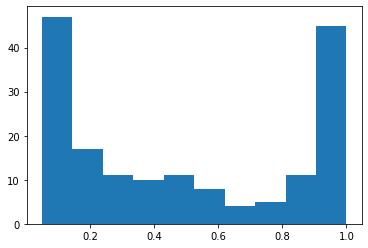

In [ ]:
plt.hist(towers2.score)

###(NOTE: explore building function that uses exact tif files as grid via rasterio)

In [ ]:
towers2['score']

In [ ]:
len(towers2.loc[towers2['score'] > 0.9])

                                                  tif  \
3   /content/drive/My Drive/PyPSA_Africa_images/ma...   
5   /content/drive/My Drive/PyPSA_Africa_images/ma...   
13  /content/drive/My Drive/PyPSA_Africa_images/ma...   
16  /content/drive/My Drive/PyPSA_Africa_images/ma...   
17  /content/drive/My Drive/PyPSA_Africa_images/ma...   

                    geometry     score  
3   POINT (-1.99673 7.98596)  0.922025  
5   POINT (-2.00090 7.98557)  0.980523  
13  POINT (-2.03093 7.98712)  0.991997  
16  POINT (-2.06242 7.98671)  0.999351  
17  POINT (-2.06261 7.98690)  0.998940  


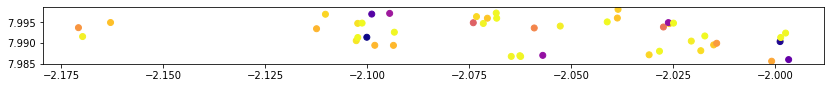

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(14, 14))
threshold = 0.9
#tifs.plot(ax=ax, alpha=0.2)
towers2.loc[towers2['score'] > threshold].plot(ax=ax, column='score', cmap='plasma')
print(towers2.loc[towers2['score'] > threshold].head())

plt.show()

<Figure size 864x720 with 0 Axes>

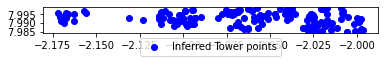

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = towers2.plot( color = 'blue', label = 'Inferred Tower points')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -.5))

## big batch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import os
import torch
from osgeo import gdal
from shapely import geometry
from torchvision import transforms
from tqdm import tqdm


def infer_towers(in_dir,
                 tifs,
                 out_dir,
                 predictor,
                 width=256,
                 height=256,
                 batch_size=100,
                 stop=10,
                 folium=False,
                 add_true=None,
                 seed=None,
                 reverse=False,
                 plot_batch=False
                 ):
    '''
    Iterate over tif files and runs batch-wise inference using model. Resulting hits are stored
    in a GeoDataFrame as shapely.geometries.Point . Returns a folium map if desired


    Parameters
    ----------
    in_dir : str
        directory where the tif files can be found
    tifs : list of str
        images in tif format that should be stored
    out_dir : str
        directory where resulting .png files should be stored
    model : torch.nn.Module
        torch model to detect transmission and distribution towers
    width : int
        number of pixels on the x-axis
    height : int
        number of pixels on the y-axis
    batch_size : int
        number of examples in each model forward pass
    stop : int
        algorithms stops execution after that number of iterations
    folium : bool
        makes the function return a folium.Map object with tif shape and found towers
    add_true : None or str
        if str, some images from that dir containing towers are replacing half of the images in each batch
    seed : int
        seed to all random operations
    reverse : bool
        if True, goes over the tif from bottom to top
    plot_batch : bool
        if True, plots the images in every batch

    Returns
    ----------
    towers : geopandas.GeoDataFrame
        dataframe of towers with columns: fn (filename of tif), geometry (shapely point geometries of towers)
    tifs : geopandas.GeoDataFrame
        dataframe of tif Polygons
    (optional) m : folium.Map
        map with all datapoints from both dataframes

    '''

    np.random.seed(seed)

    # set up dataframe to store geometries of investigated tif files
    tif_df = gpd.GeoDataFrame(columns=["filename", "geometry"]).set_crs(epsg=4326)
    # list of towers that are found in tifs
    towers_df = gpd.GeoDataFrame(columns=['tif', 'geometry', 'score']).set_crs(epsg=4326)

    if not isinstance(tifs, list):
        assert isinstance(tifs, str), f'Pass list of tif filenames, instead of {tifs}'
        tifs = [tifs]

    tifs = [os.path.join(in_dir, tif) for tif in tifs]

    for fn in tifs:

        print(f'Looking at imagery in {fn}!')

        # open files
        ds = gdal.Open(fn)
        info = gdal.Info(fn, format="json")
        bands = [ds.GetRasterBand(i) for i in range(1, 4)]

        # extract relevant geographical data
        transform = info["geoTransform"]
        upper_left = np.array([transform[0], transform[3]])
        pixel_size = np.array([transform[1], transform[5]])

        tif_width = info['size'][0]
        tif_height = info['size'][1]

        # append tif extent to dataframe
        tif_geom = geometry.Polygon([info['cornerCoordinates']['upperLeft'],
                                     info['cornerCoordinates']['lowerLeft'],
                                     info['cornerCoordinates']['lowerRight'],
                                     info['cornerCoordinates']['upperRight']])

        tif_df = tif_df.append({'filename': fn, 'geometry': tif_geom}, ignore_index=True)

        print('obtained transform: ', transform)
        print('ul: ', upper_left)
        print('pixelz: ', pixel_size)

        print('info: ', info['size'])

        num_cols = tif_width // width
        num_rows = tif_height // height

        num_batches = (num_cols * num_rows) // batch_size

        print('pngs per row {}'.format(num_cols))
        print('pngs per col {}'.format(num_rows))

        print('batch size: ', batch_size)

        # count detected instances
        instance_count = 0
        batch_count = 0

        for batch in tqdm(range(min([num_batches, stop]))):

            batch_count += 1

            if reverse:
                batch = num_batches - 1 - batch

            full_batch = np.zeros((height, 0, 3))

            # create a dataframe to connect detections to coordinates
            batch_df = pd.DataFrame(columns=['img_ul_x', 'img_ul_y'])

            start_png = batch * batch_size
            end_png = (1+batch) * batch_size

            start_col = start_png % num_cols
            end_col = end_png % num_cols

            start_row = start_png // num_cols
            end_row = end_png // num_cols

            # Go over rows contained in current batch
            for row in range(start_row, end_row+1):

                # obtain x coordinates of interest
                if row == start_row:
                    start_pixel_x = width * start_col
                else:
                    start_pixel_x = 0.

                if row == end_row:
                    end_pixel_x = width * end_col
                else:
                    end_pixel_x = width * num_cols

                row_width = int(end_pixel_x - start_pixel_x)
                start_pixel_y = row * height

                # Assign upper left corner pixel coordinates to batch_df
                img_ul_x = np.arange(start_pixel_x, end_pixel_x, width)
                img_ul_y = np.ones(row_width//width) * height * row

                appendix = pd.DataFrame({'img_ul_x': img_ul_x, 'img_ul_y': img_ul_y})
                batch_df = batch_df.append(appendix, ignore_index=True)

                row_pixels = np.ones((height, row_width, 3))
                # obtain the three bands
                for i in range(3):
                    row_pixels[:,:,i] = bands[i].ReadAsArray(start_pixel_x, start_pixel_y, row_width, height)

                full_batch = np.hstack([full_batch, row_pixels])

            # full_batch = full_batch[:, :, ::-1]

            # full_batch = torch.tensor(full_batch)
            full_batch = np.split(full_batch, full_batch.shape[1]//width, axis=1)
            #full_batch = torch.split(full_batch, [width for _ in range(batch_size)], dim=1)

            # print('initial shape')
            #print(len(full_batch))
            #for ex in full_batch:
            #     print(ex.shape)
            # return

            full_batch = [{'image': img, 'height': height, 'width': width} for img in full_batch]

            # for testing purposes: add images that have towers in them
            if add_true is not None:
                true_imgs = get_true_images(add_true, len(full_batch) // 2)
                for i, _ in enumerate(full_batch):
                    if i % 2 == 0:
                        full_batch[i]['image'] = true_imgs[i//2][:, :, ::-1]

            if plot_batch:
                print('resulting batch after adding hits')
                plot_width = 20
                fig, axs = plt.subplots(1, len(full_batch), figsize=(plot_width, plot_width/len(full_batch)))
                for ax, img in zip(axs, full_batch):
                    ax.imshow(img['image'] / 255)
                plt.show()

            for i, img in enumerate(full_batch):

                curr_img = img['image'].astype(np.uint8)

                # _, ax = plt.subplots(1, 1, figsize=(4,4))
                # ax.imshow(curr_img)
                # plt.show()

                # print(type(curr_img))
                # print('before trafo')
                # print(curr_img.shape)
                curr_img = predictor.aug.get_transform(curr_img).apply_image(curr_img)
                curr_img = torch.as_tensor(curr_img.astype('float32').transpose(2, 0, 1))
                # print('after trafo')
                # print(curr_img.size())
                img['image'] = curr_img
                full_batch[i] = img

            # print('Investigate full batch shape')

            '''
            print('len: ', len(full_batch))
            shape = full_batch[0]['image'].size()
            print('shape of first examples: ')
            print(shape)
            for i, ex in enumerate(full_batch):
                if not shape == ex['image'].size():
                    curr_shape = ex['image'].size()
                    print(f'deviation in example {i}: {curr_shape}')
            '''


            with torch.no_grad():
                pred = predictor.model(full_batch)

            for pre, (i, row) in zip(pred, batch_df.iterrows()):

                if len(pre['instances']) > 0:
                    towers_df = eval_instances2(pre, np.array([row['img_ul_x'], row['img_ul_y']]),
                                            towers_df, fn, upper_left, pixel_size)

            if batch_count == stop: break

        print('resulting towers')
        print(towers_df.head())
        print(towers_df.tail())

    if folium:
        import folium

        m = folium.Map(location=info['cornerCoordinates']['center'][::-1])

        for i, point in towers_df.geometry.iteritems():
            folium.Marker([point.coords.xy[1][0], point.coords.xy[0][0]], popup=f"Tower {i}").add_to(m)

        tifs_json = tif_df.to_json()
        tifs_json = folium.GeoJson(data=tifs_json,
                        style_function=lambda x: {'fillColor': 'orange'})
        tifs_json.add_to(m)

        return towers_df, tif_df, m

    else:
        return towers_df, tif_df


if __name__ == '__main__':

    # model_path = os.path.join('/content', 'drive', 'MyDrive', 'PyPSA_Africa_images', 'models',
    #                             '2021-11-29_frcnn_180000_dukeset', 'model_final.pth')

    model_path = '/content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth'
    # model_path = '/content/drive/MyDrive/PyPSA_Africa_images/PISA_models/11_01_2022_fake_maxar_train/model_final.pth'
    detection_thresh = 0.05
    # predictor = load_predictor(model_path, threshold=detection_thresh)
    predictor, _ = build_predictor_model(threshold=detection_thresh, model_path=model_path)
    del _

    #eval_predictor(duke_imgs[:5], model_path=model_path)

    # true_dir = '/content/drive/MyDrive/PyPSA_Africa_images/datasets/maxar_train/data'
    true_dir = None

    base_dir = '/content/drive/My Drive/PyPSA_Africa_images'
    tif_names = ['10500100103B0300.tif']
    in_dir = os.path.join(base_dir, 'maxar/ghana/raw')
    out_dir = None

    seed = 1
    towers3, tifs3, m3 = infer_towers(in_dir, tif_names, out_dir, predictor,
                             stop=500, batch_size=20, folium=True, add_true=true_dir, seed=seed, reverse=True,
                             plot_batch=False)

Building predictor from path:
/content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth
working with path:  /content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth
Looking at imagery in /content/drive/My Drive/PyPSA_Africa_images/maxar/ghana/raw/10500100103B0300.tif!
obtained transform:  [-2.177094300568735, 4.4493556022e-06, 0.0, 9.012619798895205, 0.0, -4.4493556022e-06]
ul:  [-2.1770943  9.0126198]
pixelz:  [ 4.4493556e-06 -4.4493556e-06]
info:  [41624, 231295]
pngs per row 162
pngs per col 903
batch size:  20


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
  1%|▏         | 7/500 [00:42<47:58,  5.84s/it]/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecat

resulting towers
                                                 tif  \
0  /content/drive/My Drive/PyPSA_Africa_images/ma...   
1  /content/drive/My Drive/PyPSA_Africa_images/ma...   
2  /content/drive/My Drive/PyPSA_Africa_images/ma...   
3  /content/drive/My Drive/PyPSA_Africa_images/ma...   
4  /content/drive/My Drive/PyPSA_Africa_images/ma...   

                   geometry     score  
0  POINT (-2.02162 7.98465)  0.507982  
1  POINT (-2.00573 7.98470)  0.776682  
2  POINT (-2.00573 7.98470)  0.154254  
3  POINT (-1.99673 7.98596)  0.922024  
4  POINT (-2.01503 7.98603)  0.256848  
                                                    tif  \
1035  /content/drive/My Drive/PyPSA_Africa_images/ma...   
1036  /content/drive/My Drive/PyPSA_Africa_images/ma...   
1037  /content/drive/My Drive/PyPSA_Africa_images/ma...   
1038  /content/drive/My Drive/PyPSA_Africa_images/ma...   
1039  /content/drive/My Drive/PyPSA_Africa_images/ma...   

                      geometry     score  
1035  PO

## explore base inference outputs

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = towers3.plot( color = 'blue', label = 'Inferred Tower points')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -.5))

#MST clustering

## algo

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# matplotlib 1.4 + numpy 1.10 produces warnings; we'll filter these
import warnings; warnings.filterwarnings('ignore', message='elementwise')

def plot_mst(model, cmap='rainbow'):
    """Utility code to visualize a minimum spanning tree"""
    X = model.X_fit_
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
    for axi, full_graph, colors in zip(ax, [True, False], ['lightblue', model.labels_]):
        segments = model.get_graph_segments(full_graph=full_graph)
        axi.plot(segments[0], segments[1], '-k', zorder=1, lw=1)
        axi.scatter(X[:, 0], X[:, 1], c=colors, cmap=cmap, zorder=2)
        axi.axis('tight')

    ax[0].set_title('Full Minimum Spanning Tree', size=16)
    ax[1].set_title('Trimmed Minimum Spanning Tree', size=16);

In [ ]:
"""
Minimum Spanning Tree Clustering
"""
from __future__ import division

import numpy as np

from scipy import sparse
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components
from scipy.sparse.csgraph._validation import validate_graph
from sklearn.utils import check_array

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import pairwise_distances


class MSTClustering(BaseEstimator, ClusterMixin):
    """Minimum Spanning Tree Clustering
    Parameters
    ----------
    cutoff : float, int, optional
        either the number of edges to cut (if cutoff >= 1) or the fraction of
        edges to cut (if 0 < cutoff < 1). See also the ``cutoff_scale``
        parameter.
    cutoff_scale : float, optional
        minimum size of edges. All edges larger than cutoff_scale will be
        removed (see also ``cutoff`` parameter).
    min_cluster_size : int (default: 1)
        minimum number of points per cluster. Points belonging to smaller
        clusters will be assigned to the background.
    approximate : bool, optional (default: True)
        If True, then compute the approximate minimum spanning tree using
        n_neighbors nearest neighbors. If False, then compute the full
        O[N^2] edges (see Notes, below).
    n_neighbors : int, optional (default: 20)
        maximum number of neighbors of each point used for approximate
        Euclidean minimum spanning tree (MST) algorithm.  Referenced only
        if ``approximate`` is False. See Notes below.
    metric : string (default "euclidean")
        Distance metric to use in computing distances. If "precomputed", then
        input is a [n_samples, n_samples] matrix of pairwise distances (either
        sparse, or dense with NaN/inf indicating missing edges)
    metric_params : dict or None (optional)
        dictionary of parameters passed to the metric. See documentation of
        sklearn.neighbors.NearestNeighbors for details.
    Attributes
    ----------
    full_tree_ : sparse array, shape (n_samples, n_samples)
        Full minimum spanning tree over the fit data
    T_trunc_ : sparse array, shape (n_samples, n_samples)
        Non-connected graph over the final clusters
    labels_: array, length n_samples
        Labels of each point
    Notes
    -----
    This routine uses an approximate Euclidean minimum spanning tree (MST)
    to perform hierarchical clustering.  A true Euclidean minimum spanning
    tree naively costs O[N^3].  Graph traversal algorithms only help so much,
    because all N^2 edges must be used as candidates.  In this approximate
    algorithm, we use k << N edges from each point, so that the cost is only
    O[Nk log(Nk)]. For k = N, the approximation is exact; in practice for
    well-behaved data sets, the result is exact for k << N.
    """
    def __init__(self, cutoff=None, cutoff_scale=None, min_cluster_size=1,
                 approximate=True, n_neighbors=20,
                 metric='euclidean', metric_params=None):
        self.cutoff = cutoff
        self.cutoff_scale = cutoff_scale
        self.min_cluster_size = min_cluster_size
        self.approximate = approximate
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.metric_params = metric_params

    def fit(self, X, y=None):
        """Fit the clustering model
        Parameters
        ----------
        X : array_like
            the data to be clustered: shape = [n_samples, n_features]
        """
        if self.cutoff is None and self.cutoff_scale is None:
            raise ValueError("Must specify either cutoff or cutoff_frac")

        # Compute the distance-based graph G from the points in X
        if self.metric == 'precomputed':
            # Input is already a graph. Copy if sparse
            # so we can overwrite for efficiency below.
            self.X_fit_ = None
            G = validate_graph(X, directed=True,
                               csr_output=True, dense_output=False,
                               copy_if_sparse=True, null_value_in=np.inf)
        elif not self.approximate:
            X = check_array(X)
            self.X_fit_ = X
            kwds = self.metric_params or {}
            G = pairwise_distances(X, metric=self.metric, **kwds)
            G = validate_graph(G, directed=True,
                               csr_output=True, dense_output=False,
                               copy_if_sparse=True, null_value_in=np.inf)
        else:
            # generate a sparse graph using n_neighbors of each point
            X = check_array(X)
            self.X_fit_ = X
            n_neighbors = min(self.n_neighbors, X.shape[0] - 1)
            G = kneighbors_graph(X, n_neighbors=n_neighbors,
                                 mode='distance',
                                 metric=self.metric,
                                 metric_params=self.metric_params)

        # HACK to keep explicit zeros (minimum spanning tree removes them)
        zero_fillin = G.data[G.data > 0].min() * 1E-8
        G.data[G.data == 0] = zero_fillin

        # Compute the minimum spanning tree of this graph
        self.full_tree_ = minimum_spanning_tree(G, overwrite=True)

        # undo the hack to bring back explicit zeros
        self.full_tree_[self.full_tree_ == zero_fillin] = 0

        # Partition the data by the cutoff
        N = G.shape[0] - 1
        if self.cutoff is None:
            i_cut = N
        elif 0 <= self.cutoff < 1:
            i_cut = int((1 - self.cutoff) * N)
        elif self.cutoff >= 1:
            i_cut = int(N - self.cutoff)
        else:
            raise ValueError('self.cutoff must be positive, not {0}'
                             ''.format(self.cutoff))

        # create the mask; we zero-out values where the mask is True
        N = len(self.full_tree_.data)
        if i_cut < 0:
            mask = np.ones(N, dtype=bool)
        elif i_cut >= N:
            mask = np.zeros(N, dtype=bool)
        else:
            mask = np.ones(N, dtype=bool)
            part = np.argpartition(self.full_tree_.data, i_cut)
            mask[part[:i_cut]] = False

        # additionally cut values above the ``cutoff_scale``
        if self.cutoff_scale is not None:
            mask |= (self.full_tree_.data > self.cutoff_scale)

        # Trim the tree
        cluster_graph = self.full_tree_.copy()

        # Eliminate zeros from cluster_graph for efficiency.
        # We want to do this:
        #    cluster_graph.data[mask] = 0
        #    cluster_graph.eliminate_zeros()
        # but there could be explicit zeros in our data!
        # So we call eliminate_zeros() with a stand-in data array,
        # then replace the data when we're finished.
        original_data = cluster_graph.data
        cluster_graph.data = np.arange(1, len(cluster_graph.data) + 1)
        cluster_graph.data[mask] = 0
        cluster_graph.eliminate_zeros()
        cluster_graph.data = original_data[cluster_graph.data.astype(int) - 1]

        # find connected components
        n_components, labels = connected_components(cluster_graph,
                                                    directed=False)

        # remove clusters with fewer than min_cluster_size
        counts = np.bincount(labels)
        to_remove = np.where(counts < self.min_cluster_size)[0]

        if len(to_remove) > 0:
            for i in to_remove:
                labels[labels == i] = -1
            _, labels = np.unique(labels, return_inverse=True)
            labels -= 1  # keep -1 labels the same

        # update cluster_graph by eliminating non-clusters
        # operationally, this means zeroing-out rows & columns where
        # the label is negative.
        I = sparse.eye(len(labels))
        I.data[0, labels < 0] = 0

        # we could just do this:
        #   cluster_graph = I * cluster_graph * I
        # but we want to be able to eliminate the zeros, so we use
        # the same indexing trick as above
        original_data = cluster_graph.data
        cluster_graph.data = np.arange(1, len(cluster_graph.data) + 1)
        cluster_graph = I * cluster_graph * I
        cluster_graph.eliminate_zeros()
        cluster_graph.data = original_data[cluster_graph.data.astype(int) - 1]

        self.labels_ = labels
        self.cluster_graph_ = cluster_graph
        return self

    def get_graph_segments(self, full_graph=False):
        """Convenience routine to get graph segments
        This is useful for visualization of the graph underlying the algorithm.
        Parameters
        ----------
        full_graph : bool (default: False)
            If True, return the full graph of connections. Otherwise return
            the truncated graph representing clusters.
        Returns
        -------
        segments : tuple of ndarrays
            the coordinates representing the graph. The tuple is of length
            n_features, and each array is of size (n_features, n_edges).
            For n_features=2, the graph can be visualized in matplotlib with,
            e.g. ``plt.plot(segments[0], segments[1], '-k')``
        """
        if not hasattr(self, 'X_fit_'):
            raise ValueError("Must call fit() before get_graph_segments()")
        if self.metric == 'precomputed':
            raise ValueError("Cannot use ``get_graph_segments`` "
                             "with precomputed metric.")

        n_samples, n_features = self.X_fit_.shape

        if full_graph:
            G = sparse.coo_matrix(self.full_tree_)
        else:
            G = sparse.coo_matrix(self.cluster_graph_)

        return tuple(np.vstack(arrs) for arrs in zip(self.X_fit_[G.row].T,
                                                     self.X_fit_[G.col].T))

##test

In [ ]:
def return_coords_df(df):
    gh_twr_df = df
    gh_twr_df['lon'] = gh_twr_df.geometry.apply(lambda p: p.x)
    gh_twr_df['lat'] = gh_twr_df.geometry.apply(lambda p: p.y)

    # represent points consistently as (lat, lon)
    #coords_df = gh_twr_df[['lat', 'lon']]
    coords_df = gh_twr_df[['lon', 'lat']] # for visualiszing MST which seems to flip them

    return coords_df


def return_nparr_from_df(df):
  gh_twr_hits_coords_df = return_coords_df(df)
  test_pts = gh_twr_hits_coords_df.to_numpy()
  return test_pts

In [ ]:
gh_twr_hits_coords_df = return_coords_df(gh_twr_hits)

In [ ]:
gh_twr_hits = towers2.loc[towers2['score'] > .9]
plt.hist(gh_twr_hits.score)

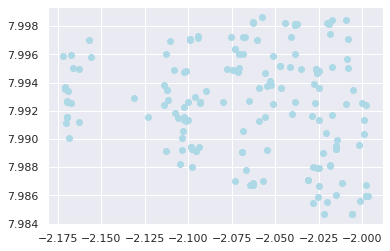

In [ ]:
X = return_nparr_from_df(towers2)
plt.scatter(X[:, 0], X[:, 1], c='lightblue');

In [ ]:
#### note can use accuracy as cutoff here, knowing from validation about 50% of hits are actually towers
X = return_nparr_from_df(towers2)
noisy_model = MSTClustering(cutoff = .5 , min_cluster_size = 2)
noisy_model.fit(X)
plot_mst(noisy_model, cmap='Spectral_r')

NameError: ignored

In [ ]:
#### note can use accuracy as cutoff here, knowing from validation about 50% of hits are actually towers
X = return_nparr_from_df(gh_twr_hits)
noisy_model = MSTClustering(cutoff = .1 , min_cluster_size = 2)
noisy_model.fit(X)
plot_mst(noisy_model, cmap='Spectral_r')

#PyOD version

In [ ]:
### there is lots of options available here
# noise added from gaussian of points, or detection of entire country level

#https://github.com/yzhao062/pyod#quick-start-for-outlier-detection

In [ ]:
clusters = noisy_model.labels_
data = pd.DataFrame()
data['cluster'] = clusters

In [ ]:
data = pd.DataFrame()
data['cluster'] = clusters

In [ ]:
clusters

In [ ]:
data

In [ ]:
df_cluster=pd.DataFrame(clusters)

In [ ]:
df_cluster

In [ ]:
df = towers2
df_cluster=data
ind_outlier=df_cluster.index[df_cluster['cluster']==-1]
for i in ind_outlier:
  df_final = df.drop(ind_outlier)

###gridfinder inference comp

In [ ]:
n_cells = 500
twr_df = df_final

network_guess_stoch, thinned_network_guess_stoch = network_inference_array_v2_1(twr_df, n_cells, cutoff = .000001,  random_start = False)
lines_guess_gdf_stoch = convert_guess_to_gdf_multilines(thinned_network_guess_stoch, twr_df, n_cells)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

(-2.2, -1.99)

<Figure size 864x720 with 0 Axes>

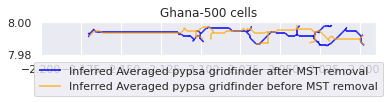

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder after MST removal')
lines_guess_gdf_stoch2.plot(ax = ax, color = 'orange', alpha = .75, label = 'Inferred Averaged pypsa gridfinder before MST removal')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.75) )
ax.set_title("Ghana-500 cells")
ax.set_ylim(7.98, 8.0)
ax.set_xlim(-2.2, -1.99)

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

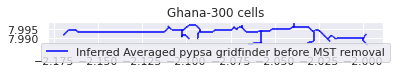

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch2.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder before MST removal')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

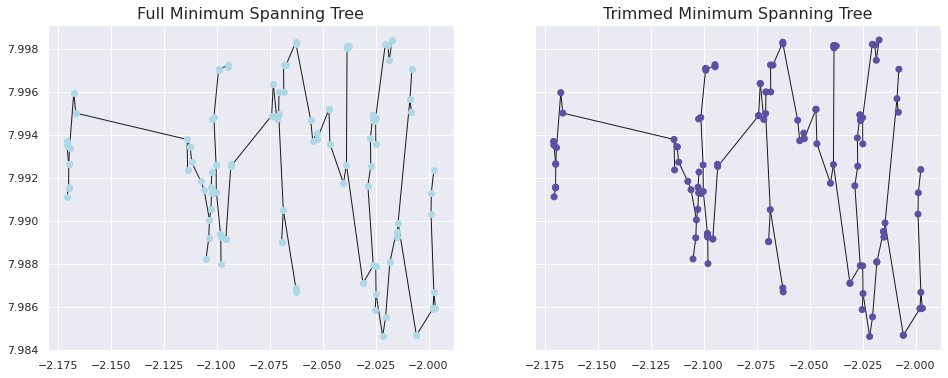

In [ ]:
X = return_nparr_from_df(df_final)
noisy_model = MSTClustering(cutoff = 0)
noisy_model.fit(X)
plot_mst(noisy_model, cmap='Spectral_r')

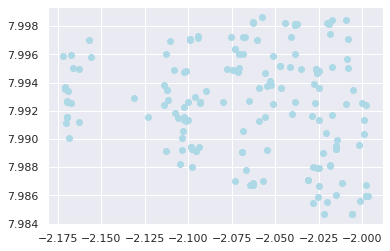

In [ ]:
X = return_nparr_from_df(towers2)
plt.scatter(X[:, 0], X[:, 1], c='lightblue');

In [ ]:
df_final

<Figure size 864x720 with 0 Axes>

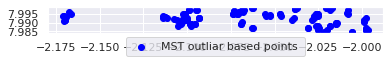

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = df_final.plot( color = 'blue', label = 'MST outliar based points ')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -.5))

<Figure size 864x720 with 0 Axes>

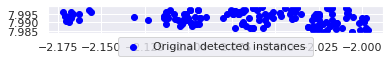

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = towers2.plot( color = 'blue', label = 'Original detected instances ')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -.5))

## all of ghana test

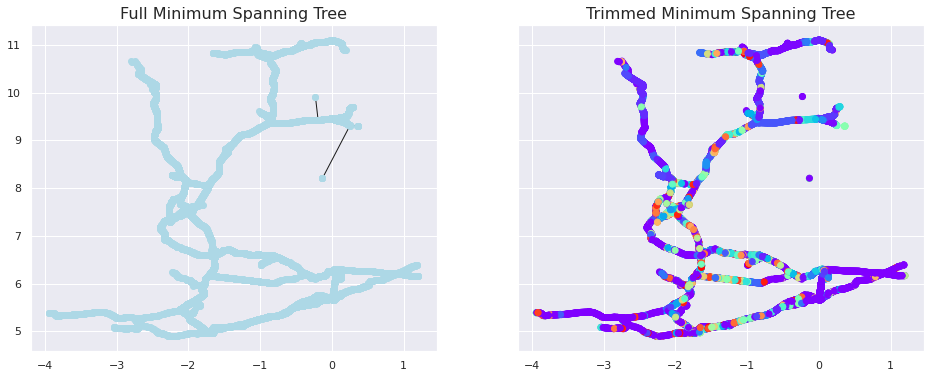

In [ ]:
X = return_nparr_from_df(gh_twr_df)
noisy_model = MSTClustering(cutoff = .25 , min_cluster_size = 3)
noisy_model.fit(X)
plot_mst(noisy_model)

In [ ]:
noisy_model.labels_

array([ -1,   0,  -1, ...,   8,  93, 521])

# gridfinder

##setup

In [ ]:
import geopandas as gpd
import pandas as pd

from pathlib import Path
folder_out = Path('test_output')
guess_skeletonized_out = folder_out / 'guess_skel.tif'



from heapq import heapify, heappush, heappop
import pickle
import rasterio
from IPython.display import display, Markdown
from math import sqrt
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from skimage.morphology import skeletonize
import shapely.wkt
from shapely.geometry import Point, LineString, MultiLineString
import rasterio
from rasterio.features import rasterize
from rasterio.transform import xy

## preprocessing

In [ ]:
# note that these are for now specific to extrating tower data
def gdf_2_gridded_conversion(gdf, n_cells):
    xmin, ymin, xmax, ymax= gdf.total_bounds
  # how many cells for range of x values investigated - can be customized for y if needed
  #n_cells=30
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                    crs=crs)


    merged = gpd.sjoin(gdf, cell, how='left', op='within')

    #clean_merge = merged.drop(labels =['tags.power', 'tags.material', 'tags.height', 'tags.structure',
        #'tags.line_management', 'Type', 'Country'], axis = 1)

    #clean_merge = merged.drop(labels =['tags.power', 'Type', 'Country'], axis = 1)
    clean_merge = merged.loc[:, ['id', 'geometry', 'index_right']]
    ## removing nan which can cause error
    merged2 = clean_merge.dropna(axis = 0, how = 'any')

    return merged2 , cell

def gdf_2_binary_gridded_conversion(gdf, n_cells):
    merged2, cell = gdf_2_gridded_conversion(gdf, n_cells)

    # make a simple count variable that we can sum
    merged2['n_twr']=1
    # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
    dissolve = merged2.dissolve(by="index_right", aggfunc="count")
    # put this into cell
    cell.loc[dissolve.index, 'n_twr'] = dissolve.n_twr.values


    return cell


def line_gdf_2_gridded_conversion(gdf, n_cells):
    xmin, ymin, xmax, ymax= gdf.total_bounds
  # how many cells for range of x values investigated - can be customized for y if needed
  #n_cells=30
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                    crs=crs)


    merged = gpd.sjoin(gdf, cell, how='left', op='within')

    #clean_merge = merged.drop(labels =['tags.power', 'tags.cables', 'tags.voltage', 'tags.frequency',
        #'Type', 'Country'], axis = 1)

    clean_merge = merged
    ## removing nan which can cause error
    merged2 = clean_merge.dropna(axis = 0, how = 'any')

    return merged2 , cell

def line_gdf_2_binary_gridded_conversion(gdf, n_cells):
    merged2, cell = line_gdf_2_gridded_conversion(gdf, n_cells)

    # make a simple count variable that we can sum
    merged2['n_lines']=1
    # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
    dissolve = merged2.dissolve(by="index_right", aggfunc="count")
    # put this into cell
    cell.loc[dissolve.index, 'n_lines'] = dissolve.n_lines.values


    return cell

# note that these are for now specific to extrating tower data
def guess_line_gdf_2_gridded_conversion(gdf, true_line_df, n_cells):
    xmin, ymin, xmax, ymax= gdf.total_bounds
  # how many cells for range of x values investigated - can be customized for y if needed
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                    crs=crs)


    merged = gpd.sjoin(gdf, cell, how='left', op='within')

    #clean_merge = merged.drop(labels =['tags.power', 'tags.cables', 'tags.voltage', 'tags.frequency',
        #'Type', 'Country'], axis = 1)

    clean_merge = merged
    ## removing nan which can cause error
    merged2 = clean_merge.dropna(axis = 0, how = 'any')

    return merged2 , cell

def guess_line_gdf_2_binary_gridded_conversion(gdf, true_line_df, n_cells):
    merged2, cell = guess_line_gdf_2_gridded_conversion(gdf, true_line_df, n_cells)

    # make a simple count variable that we can sum
    merged2['n_lines']=1
    # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
    dissolve = merged2.dissolve(by="index_right", aggfunc="count")
    # put this into cell
    cell.loc[dissolve.index, 'n_lines'] = dissolve.n_lines.values


    return cell


# note that these are for now specific to extrating tower data
def guess_line_gdf_2_gridded_conversion(gdf, true_line_df, n_cells):
    xmin, ymin, xmax, ymax= gdf.total_bounds
  # how many cells for range of x values investigated - can be customized for y if needed
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                    crs=crs)


    merged = gpd.sjoin(gdf, cell, how='left', op='within')

    #clean_merge = merged.drop(labels =['tags.power', 'tags.cables', 'tags.voltage', 'tags.frequency',
        #'Type', 'Country'], axis = 1)

    clean_merge = merged
    ## removing nan which can cause error
    merged2 = clean_merge.dropna(axis = 0, how = 'any')

    return merged2 , cell

def guess_line_gdf_2_binary_gridded_conversion(gdf, true_line_df, n_cells):
    merged2, cell = guess_line_gdf_2_gridded_conversion(gdf, true_line_df, n_cells)

    # make a simple count variable that we can sum
    merged2['n_lines']=1
    # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
    dissolve = merged2.dissolve(by="index_right", aggfunc="count")
    # put this into cell
    cell.loc[dissolve.index, 'n_lines'] = dissolve.n_lines.values


    return cell



def m_distance_sline_all_towers(gh_coord_test):
  gh_coord_test_crs = gh_coord_test.to_crs('EPSG:5234')
  gh_coord_test_crs2 = gh_coord_test_crs.shift()
  dists =[]
  for gv in range(len(gh_coord_test_crs)):
    pt = gh_coord_test_crs[gv]
    dists.append(gh_coord_test_crs.distance(pt))
  return dists

def unpack_all_tower_coords(gh_coord_test):
  labeled_twr_coords =[]
  for i in range(len(gh_coord_test.geometry)):
      i_coord = list(gh_coord_test.geometry.iloc[i].coords)
      mylist_n = [j for i in i_coord for j in i] # unpack list so linestring format compatible with EE
      labeled_twr_coords.append(mylist_n)
  return labeled_twr_coords



def return_idx_lines_gridded(cell, n_cells): #cell here is df containing both shapely polygon grids and original tower point markers , ncells to number of cells in x coordinate system for now
  # total area for the grid
  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  gps = []
  #find location in grid ####
  for i in range(len(cell)):
    if cell["n_lines"][i] ==1:
      #print(i)
      twr_grid_cnt = list(cell.iloc[i].geometry.centroid.coords)
      yic = twr_grid_cnt[0][1]
      xic = twr_grid_cnt[0][0]
  #### now retrieve integer indexing #####
      yi = int((yic- ymin) / cell_size)
      xi = int((xic- xmin) / cell_size)

      gps.append((yi,xi))
  return gps


def return_idx_twr_gridded(cell, n_cells): #cell here is df containing both shapely polygon grids and original tower point markers , ncells to number of cells in x coordinate system for now
  # total area for the grid
  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  gps = []
  #find location in grid ####
  for i in range(len(cell)):
    if cell["n_twr"][i] ==1:
      #print(i)
      twr_grid_cnt = list(cell.iloc[i].geometry.centroid.coords)
      yic = twr_grid_cnt[0][1]
      xic = twr_grid_cnt[0][0]
  #### now retrieve integer indexing #####
      yi = int((yic- ymin) / cell_size)
      xi = int((xic- xmin) / cell_size)

      gps.append((yi,xi))
  return gps



def lines_df_to_2d_target_array(cell, n_cells):

  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  # define number of x and y cells used for indexing
  nxcell = int((xmax - xmin) / cell_size)
  nycell = int((ymax - ymin) / cell_size)

  twr_pts_idx = return_idx_lines_gridded(cell, n_cells)

  points = twr_pts_idx
  targets = np.zeros((int(nycell+1), int(nxcell+1)))
  targets[tuple(np.array(points).T)] = 1
  #targets[tuple(np.array(points))] = 1
  #equal costs for all cells - excluding road info etc
  costs = np.ones((int(nycell+1), int(nxcell+1)))

  ## flip to be consistent with original gridded
  t = np.flip(targets, 0)
  c = np.flip(costs, 0)

  return t, c


def lines_df_to_2d_target_array2(cell, truth_cell, n_cells):

  gdf = truth_cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  # define number of x and y cells used for indexing
  nxcell = int((xmax - xmin) / cell_size)
  nycell = int((ymax - ymin) / cell_size)

  twr_pts_idx = return_idx_lines_gridded(cell, n_cells)

  points = twr_pts_idx
  targets = np.zeros((int(nycell+1), int(nxcell+1)))
  targets[tuple(np.array(points).T)] = 1
  #targets[tuple(np.array(points))] = 1
  #equal costs for all cells - excluding road info etc
  costs = np.ones((int(nycell+1), int(nxcell+1)))

  ## flip to be consistent with original gridded
  t = np.flip(targets, 0)
  c = np.flip(costs, 0)

  return t, c


def pts_df_to_2d_target_array(cell, n_cells):

  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  # define number of x and y cells used for indexing
  nxcell = int((xmax - xmin) / cell_size)
  nycell = int((ymax - ymin) / cell_size)

  twr_pts_idx = return_idx_twr_gridded(cell, n_cells)

  points = twr_pts_idx
  targets = np.zeros((int(nycell+1), int(nxcell+1)))
  targets[tuple(np.array(points).T)] = 1
  #targets[tuple(np.array(points))] = 1
  #equal costs for all cells - excluding road info etc
  costs = np.ones((int(nycell+1), int(nxcell+1)))

  ## flip to be consistent with original gridded
  t = np.flip(targets, 0)
  c = np.flip(costs, 0)

  return t, c


def linestring_to_points(line):
    return line.coords


def line_2_pts_geodf(gdf):
  from shapely.geometry import MultiPoint

  split_line_pt_guess_df = gdf.explode(ignore_index = True)
  split_line_pt_guess_df['points'] = split_line_pt_guess_df.apply(lambda l: linestring_to_points(l['geometry']),axis=1)
  split_line_pt_guess_df['multi_points'] = split_line_pt_guess_df.apply(lambda l: MultiPoint(l['points']),axis=1)
  a = split_line_pt_guess_df['multi_points'].explode(ignore_index = True)
  final_guess_pt_df = gpd.GeoDataFrame(geometry = a)
  return final_guess_pt_df

def get_line_points_intersection(lines):
    point_intersections = []
    lines_len = len(lines)
    for i in range(lines_len):
        for j in range(i+1, lines_len): #to avoid computing twice the same intersection we do some index handling
            l1, l2 = lines[i], lines[j]
            if l1.intersects(l2):
                intersection = l1.intersection(l2)
                point_intersections.append(intersection)

    return point_intersections


##post

In [ ]:
def save_raster(path, raster, affine, crs=None, nodata=0):
    """Save a raster to the specified file.
    Parameters
    ----------
    file : str
        Output file path
    raster : numpy.array
        2D numpy array containing raster values
    affine: affine.Affine
        Affine transformation for the raster
    crs: str, proj.Proj, optional (default EPSG4326)
        CRS for the raster
    """

    path = Path(path)
    if not path.parents[0].exists():
        path.parents[0].mkdir(parents=True, exist_ok=True)

    if not crs:
        crs = "+proj=latlong"

    filtered_out = rasterio.open(
        path,
        "w",
        driver="GTiff",
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=crs,
        transform=affine,
        nodata=nodata,
    )
    filtered_out.write(raster, 1)
    filtered_out.close()



# converting outputs from alkgoirthm numpy arrrat form back to geodataframr

def convert_guess_to_gdf_multilines(thinned_network_guess, original_gdf, n_cells):

  gdf = original_gdf
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  #arr = network_guess
  arr = np.flip(thinned_network_guess,0)

  max_row = arr.shape[0]
  max_col = arr.shape[1]

  lines = []

  for row in range(0, max_row):
      for col in range(0, max_col):
          loc = (row, col)
          if arr[loc] == 1:
              for i in range(-1, 2):
                  for j in range(-1, 2):
                      next_row = row + i
                      next_col = col + j
                      next_loc = (next_row, next_col)

                      # ensure we're within bounds
                      # ensure we're not looking at the same spot
                      if (
                          next_row < 0
                          or next_col < 0
                          or next_row >= max_row
                          or next_col >= max_col
                          or next_loc == loc
                      ):
                          continue

                      if arr[next_loc] == 1:
                          line = (loc, next_loc)
                          rev = (line[1], line[0])
                          if line not in lines and rev not in lines:
                              lines.append(line)


  real_lines = []
  for line in lines:
      xi = line[0][1]
      yi = line[0][0]
      ycoord = yi*cell_size + ymin
      xcoord = xi*cell_size + xmin
  #second set of points
      xi2 = line[1][1]
      yi2 = line[1][0]
      ycoord2 = yi2*cell_size + ymin
      xcoord2 = xi2*cell_size + xmin


      real =((xcoord, ycoord), (xcoord2, ycoord2))
      real_lines.append(real)


  shapes = []
  for line in real_lines:
    #print(line[1])
    shapes.append(LineString([Point(line[0]), Point(line[1])]).wkt)


  guess_gdf = pd.DataFrame(shapes)
  geometry = guess_gdf[0].map(shapely.wkt.loads)
  guess_gdf = guess_gdf.drop(0, axis=1)
  guess_gdf = gpd.GeoDataFrame(guess_gdf, geometry=geometry)

  guess_gdf = guess_gdf.set_crs('epsg:4326')

  guess_gdf["same"] = 0
  guess_gdf = guess_gdf.dissolve(by="same")
  guess_gdf = guess_gdf.to_crs(epsg=4326)

  return guess_gdf

def convert_guess_to_gdf_multilines2(thinned_network_guess, original_gdf, n_cells, treshold = .05):

  gdf = original_gdf
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  #arr = network_guess
  arr = np.flip(thinned_network_guess,0)

  max_row = arr.shape[0]
  max_col = arr.shape[1]

  lines = []

  for row in range(0, max_row):
      for col in range(0, max_col):
          loc = (row, col)
          #if arr[loc] == 1:
          if arr[loc] >= treshold:
              for i in range(-1, 2):
                  for j in range(-1, 2):
                      next_row = row + i
                      next_col = col + j
                      next_loc = (next_row, next_col)

                      # ensure we're within bounds
                      # ensure we're not looking at the same spot
                      if (
                          next_row < 0
                          or next_col < 0
                          or next_row >= max_row
                          or next_col >= max_col
                          or next_loc == loc
                      ):
                          continue

                      if arr[next_loc] == 1:
                          line = (loc, next_loc)
                          rev = (line[1], line[0])
                          if line not in lines and rev not in lines:
                              lines.append(line)


  real_lines = []
  for line in lines:
      xi = line[0][1]
      yi = line[0][0]
      ycoord = yi*cell_size + ymin
      xcoord = xi*cell_size + xmin
  #second set of points
      xi2 = line[1][1]
      yi2 = line[1][0]
      ycoord2 = yi2*cell_size + ymin
      xcoord2 = xi2*cell_size + xmin


      real =((xcoord, ycoord), (xcoord2, ycoord2))
      real_lines.append(real)


  shapes = []
  for line in real_lines:
    #print(line[1])
    shapes.append(LineString([Point(line[0]), Point(line[1])]).wkt)


  guess_gdf = pd.DataFrame(shapes)
  geometry = guess_gdf[0].map(shapely.wkt.loads)
  guess_gdf = guess_gdf.drop(0, axis=1)
  guess_gdf = gpd.GeoDataFrame(guess_gdf, geometry=geometry)

  guess_gdf = guess_gdf.set_crs('epsg:4326')

  guess_gdf["same"] = 0
  guess_gdf = guess_gdf.dissolve(by="same")
  guess_gdf = guess_gdf.to_crs(epsg=4326)

  return guess_gdf


def convert_guess_to_gdf_pts(thinned_network_guess, original_gdf, n_cells):
  gdf = original_gdf
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells
  arr = thinned_network_guess

  max_row = arr.shape[0]
  max_col = arr.shape[1]

  lines = []
  line_pts = []

  for row in range(0, max_row):
      for col in range(0, max_col):
          loc = (row, col)
          if arr[loc] == 1:
            line_pts.append(loc)


  real_lines_pts = []
  for line in line_pts:
      xi = line[1]
      yi = line[0]
      ycoord = yi*cell_size + ymin
      xcoord = xi*cell_size + xmin

      real =(xcoord, ycoord)
      real_lines_pts.append(real)


  shapes = []
  for line in real_lines_pts:
    #print(line[1])
    shapes.append(Point(line[0],line[1]).wkt)


  guess_gdf = pd.DataFrame(shapes)
  geometry = guess_gdf[0].map(shapely.wkt.loads)
  guess_gdf = guess_gdf.drop(0, axis=1)
  guess_gdf = gpd.GeoDataFrame(guess_gdf, geometry=geometry)

  guess_gdf = guess_gdf.set_crs('epsg:4326')

  guess_gdf["same"] = 0
  guess_gdf = guess_gdf.dissolve(by="same")
  guess_gdf = guess_gdf.to_crs(epsg=4326)
  return guess_gdf

## optimisation

In [ ]:
def optimise(
    targets,
    costs,
    start,
    jupyter=False,
    animate=False,
    affine=None,
    animate_path=None,
    silent=False,
):
    """Run the Dijkstra algorithm for the supplied arrays.
    Parameters
    ----------
    targets : numpy array
        2D array of targets which includes only towers for now. Will be extended to towns and villages in v2.
    costs : numpy array
        2D array of costs. These are initialised all to 1 for now but will include cost based on osm road data in v2.
    start : tuple
        Two-element tuple with row, col of starting point.
    jupyter : boolean, optional (default False)
        Whether the code is being run from a Jupyter Notebook.
    Returns
    -------
    dist : numpy array
        2D array with the distance (in cells) of each point from a 'found'
        on-grid point. Values of 0 imply that cell is part of a grid line.
    """

    max_i = costs.shape[0]
    max_j = costs.shape[1]

    visited = np.zeros_like(targets, dtype=np.int8)
    dist = np.full_like(costs, np.nan, dtype=np.float32)

    # want to set this to dtype='int32, int32'
    # but then the if type(prev_loc) == tuple check will break
    # becuas it gets instantiated with tuples
    prev = np.full_like(costs, np.nan, dtype=object)

    dist[start] = 0

    #       dist, loc
    queue = [[0, start]]
    heapify(queue)

    def zero_and_heap_path(loc):
        """Zero the location's distance value and follow upstream doing same.
        Parameters
        ----------
        loc : tuple
            row, col of current point.
        """

        if not dist[loc] == 0:
            dist[loc] = 0
            visited[loc] = 1

            heappush(queue, [0, loc])
            prev_loc = prev[loc]

            if type(prev_loc) == tuple:
                zero_and_heap_path(prev_loc)

    counter = 0
    progress = 0
    max_cells = targets.shape[0] * targets.shape[1]
    if jupyter:
        handle = display(Markdown(""), display_id=True)

    while len(queue):
        current = heappop(queue)
        current_loc = current[1]
        current_i = current_loc[0]
        current_j = current_loc[1]
        current_dist = dist[current_loc]

        for x in range(-1, 2):
            for y in range(-1, 2):
                next_i = current_i + x
                next_j = current_j + y
                next_loc = (next_i, next_j)

                # ensure we're within bounds
                if next_i < 0 or next_j < 0 or next_i >= max_i or next_j >= max_j:
                    continue

                # ensure we're not looking at the same spot
                if next_loc == current_loc:
                    continue

                # skip if we've already set dist to 0
                if dist[next_loc] == 0:
                    continue

                # if the location is connected
                if targets[next_loc]:
                    prev[next_loc] = current_loc
                    zero_and_heap_path(next_loc)

                # otherwise it's a normal queue cell
                else:
                    dist_add = costs[next_loc]
                    if x == 0 or y == 0:  # if this cell is  up/down/left/right
                        dist_add *= 1
                    else:  # or if it's diagonal
                        dist_add *= sqrt(2)

                    next_dist = current_dist + dist_add

                    if visited[next_loc]:
                        if next_dist < dist[next_loc]:
                            dist[next_loc] = next_dist
                            prev[next_loc] = current_loc
                            heappush(queue, [next_dist, next_loc])

                    else:
                        heappush(queue, [next_dist, next_loc])
                        visited[next_loc] = 1
                        dist[next_loc] = next_dist
                        prev[next_loc] = current_loc

                        counter += 1
                        progress_new = 100 * counter / max_cells
                        if int(progress_new) > int(progress):
                            progress = progress_new
                            message = f"{progress:.2f} %"
                            if jupyter:
                                handle.update(message)
                            elif not silent:
                                print(message)
                            if animate:
                                i = int(progress)
                                path = os.path.join(animate_path, f"arr{i:03d}.tif")
                                save_raster(path, dist, affine)

    return dist


def threshold(dists_in, cutoff=0.5):
    """Convert distance array into binary array of connected locations.
    Parameters
    ----------
    dists_in : path-like or numpy array
        2D array output from gridfinder algorithm.
    cutoff : float, optional (default 0.5.)
        Cutoff value below which consider the cells to be grid.
    Returns
    -------
    guess : numpy array
        Binary representation of input array.
    affine: affine.Affine
        Affine transformation for raster.
    """
    if isinstance(dists_in, (str, Path)):
        dists_rd = rasterio.open(dists_in)
        dists_r = dists_rd.read(1)
        affine = dists_rd.transform

        guess = dists_r.copy()
        guess[dists_r > cutoff] = 0
        guess[dists_r <= cutoff] = 1

        return guess, affine

    elif isinstance(dists_in, np.ndarray):
        guess = dists_in.copy()
        guess[dists_in > cutoff] = 0
        guess[dists_in <= cutoff] = 1

        return guess

    else:
        raise ValueError


def thin(guess_in):
    """
    Use scikit-image skeletonize to 'thin' the guess raster.
    Parameters
    ----------
    guess_in : path-like or 2D array
        Output from threshold().
    Returns
    -------
    guess_skel : numpy array
        Thinned version.
    affine : Affine
        Only if path-like supplied.
    """

    if isinstance(guess_in, (str, Path)):
        guess_rd = rasterio.open(guess_in)
        guess_arr = guess_rd.read(1)
        affine = guess_rd.transform

        guess_skel = skeletonize(guess_arr)
        guess_skel = guess_skel.astype("int32")

        return guess_skel, affine

    elif isinstance(guess_in, np.ndarray):
        guess_skel = skeletonize(guess_in)
        guess_skel = guess_skel.astype("int32")

        return guess_skel

    else:
        raise ValueError

## MST clustering

##inference

In [ ]:
def network_inference_array_v2(gdf, n_cells, random_start = True ):
    """ Calculate the most likely network structure in Numpy 2d array format output from algorithm. Values of 1 correspond to cells with grid, 0 with not.

        Parameters
        ----------
        gdf = GeoDataframe containing the locations of different towers available, each represented as a single shapely Point.

        n_cells = number of cells to split are investigated into to run gridfinder algo. More cells are more accurate but take much longer to run.


        Returns
        -------

        guess = Network inferred in 2D array format
        guess_skel = Skeletonized/thinned version of network inferred in 2D array format

    """

    cell = gdf_2_binary_gridded_conversion(gdf, n_cells)

  #### obtain 2d numpy representation to run gridfinder algo
    targets, costs = pts_df_to_2d_target_array(cell, n_cells)

    target_list = np.argwhere(targets == 1.0)

    if random_start == True:
      random_idx = np.random.randint(1,len(target_list))
      start = tuple(target_list[random_idx].tolist())
    else:
      start = tuple(target_list[0].tolist())

    dist = optimise(targets, costs, start, jupyter=True)

    guess = threshold(dist)

    guess_skel = thin(guess)

    return guess, guess_skel

def network_inference_array_v3(gdf, n_cells, random_start = True , multiple_starts = 3):
    """ Calculate the most likely network structure in Numpy 2d array format output from algorithm. Values of 1 correspond to cells with grid, 0 with not.

        Parameters
        ----------
        gdf = GeoDataframe containing the locations of different towers available, each represented as a single shapely Point.

        n_cells = number of cells to split are investigated into to run gridfinder algo. More cells are more accurate but take much longer to run.


        Returns
        -------

        guess = Network inferred in 2D array format
        guess_skel = Skeletonized/thinned version of network inferred in 2D array format

    """

    cell = gdf_2_binary_gridded_conversion(gdf, n_cells)

  #### obtain 2d numpy representation to run gridfinder algo
    targets, costs = pts_df_to_2d_target_array(cell, n_cells)

    target_list = np.argwhere(targets == 1.0)

    guesses = []
    guess_skels = []
    for i in range(multiple_starts):
      if random_start == True:
        random_idx = np.random.randint(1,len(target_list))
        start = tuple(target_list[random_idx].tolist())
      else:
        start = tuple(target_list[0].tolist())

      dist = optimise(targets, costs, start, jupyter=True)

      guess = threshold(dist)
      guess_skel = thin(guess)

      guesses.append(guess)
      guess_skels.append(guess_skel)

    avg_guess = np.mean(guesses, axis = 0)
    avg_guess_skel = np.mean(guess_skels, axis = 0)
    #return guesses, guess_skels
    return avg_guess, avg_guess_skel

def convert_guess_to_gdf_multilines3(thinned_network_guess_list, original_gdf, n_cells, treshold = .005):

  gdf = original_gdf
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  lines = []
  for thinned_network_guess in thinned_network_guess_list:
    #arr = network_guess
    arr = np.flip(thinned_network_guess,0)

    max_row = arr.shape[0]
    max_col = arr.shape[1]

    #lines = []

    for row in range(0, max_row):
        for col in range(0, max_col):
            loc = (row, col)
            if arr[loc] == 1:
            #if arr[loc] > 0.0:
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        next_row = row + i
                        next_col = col + j
                        next_loc = (next_row, next_col)

                        # ensure we're within bounds
                        # ensure we're not looking at the same spot
                        if (
                            next_row < 0
                            or next_col < 0
                            or next_row >= max_row
                            or next_col >= max_col
                            or next_loc == loc
                        ):
                            continue

                        if arr[next_loc] == 1:
                            line = (loc, next_loc)
                            rev = (line[1], line[0])
                            if line not in lines and rev not in lines:
                                lines.append(line)


  real_lines = []
  for line in lines:
      xi = line[0][1]
      yi = line[0][0]
      ycoord = yi*cell_size + ymin
      xcoord = xi*cell_size + xmin
  #second set of points
      xi2 = line[1][1]
      yi2 = line[1][0]
      ycoord2 = yi2*cell_size + ymin
      xcoord2 = xi2*cell_size + xmin


      real =((xcoord, ycoord), (xcoord2, ycoord2))
      real_lines.append(real)


  shapes = []
  for line in real_lines:
    #print(line[1])
    shapes.append(LineString([Point(line[0]), Point(line[1])]).wkt)


  guess_gdf = pd.DataFrame(shapes)
  geometry = guess_gdf[0].map(shapely.wkt.loads)
  guess_gdf = guess_gdf.drop(0, axis=1)
  guess_gdf = gpd.GeoDataFrame(guess_gdf, geometry=geometry)

  guess_gdf = guess_gdf.set_crs('epsg:4326')

  guess_gdf["same"] = 0
  guess_gdf = guess_gdf.dissolve(by="same")
  guess_gdf = guess_gdf.to_crs(epsg=4326)

  return guess_gdf

## inference function from predictor output

In [ ]:
# note that these are for now specific to extrating tower data
def gdf_2_gridded_conversion_2(gdf, n_cells):
    xmin, ymin, xmax, ymax= gdf.total_bounds
  # how many cells for range of x values investigated - can be customized for y if needed
  #n_cells=30
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                    crs=crs)


    merged = gpd.sjoin(gdf, cell, how='left', op='within')

    #clean_merge = merged.drop(labels =['tags.power', 'tags.material', 'tags.height', 'tags.structure',
        #'tags.line_management', 'Type', 'Country'], axis = 1)

    #clean_merge = merged.drop(labels =['tags.power', 'Type', 'Country'], axis = 1)
    #clean_merge = merged.loc[:, ['id', 'geometry', 'index_right']]

    clean_merge = merged
    ## removing nan which can cause error
    merged2 = clean_merge.dropna(axis = 0, how = 'any')

    return merged2 , cell

def gdf_2_binary_gridded_conversion_2(gdf, n_cells):
    merged2, cell = gdf_2_gridded_conversion_2(gdf, n_cells)

    # make a simple count variable that we can sum
    merged2['n_twr']=1
    # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
    dissolve = merged2.dissolve(by="index_right", aggfunc="count")
    # put this into cell
    cell.loc[dissolve.index, 'n_twr'] = dissolve.n_twr.values


    return cell

In [ ]:
def network_inference_array_v2_1(gdf, n_cells, cutoff, random_start = True ):
    """ Calculate the most likely network structure in Numpy 2d array format output from algorithm. Values of 1 correspond to cells with grid, 0 with not.

        Parameters
        ----------
        gdf = GeoDataframe containing the locations of different towers available, each represented as a single shapely Point.

        n_cells = number of cells to split are investigated into to run gridfinder algo. More cells are more accurate but take much longer to run.


        Returns
        -------

        guess = Network inferred in 2D array format
        guess_skel = Skeletonized/thinned version of network inferred in 2D array format

    """

    cell = gdf_2_binary_gridded_conversion_2(gdf, n_cells)

  #### obtain 2d numpy representation to run gridfinder algo
    targets, costs = pts_df_to_2d_target_array(cell, n_cells)

    target_list = np.argwhere(targets == 1.0)

    if random_start == True:
      random_idx = np.random.randint(1,len(target_list))
      start = tuple(target_list[random_idx].tolist())
    else:
      start = tuple(target_list[0].tolist())

    dist = optimise(targets, costs, start, jupyter=True)

    guess = threshold(dist, cutoff = cutoff )

    guess_skel = thin(guess)

    return guess, guess_skel

# gridfinder inference on model outputs

## inference on detected towers

(array([47., 17., 11., 10., 11.,  8.,  4.,  5., 11., 45.]),
 array([0.0502355 , 0.14520879, 0.24018208, 0.33515537, 0.43012866,
        0.52510195, 0.62007525, 0.71504854, 0.81002183, 0.90499512,
        0.99996841]),
 <a list of 10 Patch objects>)

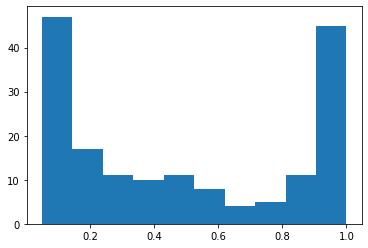

In [ ]:
plt.hist(towers2.score)

(array([ 2.,  2.,  0.,  3.,  0.,  1.,  1.,  4.,  8., 25.]),
 array([0.90423685, 0.91381001, 0.92338316, 0.93295632, 0.94252948,
        0.95210263, 0.96167579, 0.97124894, 0.9808221 , 0.99039525,
        0.99996841]),
 <a list of 10 Patch objects>)

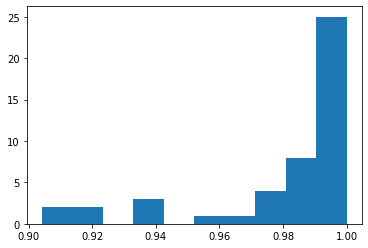

In [ ]:
gh_twr_hits = towers2.loc[towers2['score'] > .9]
plt.hist(gh_twr_hits.score)

In [ ]:
## investigate impact of cutoff float on inferred grid and if points are left out
n_cells = 500
twr_df = gh_twr_hits

network_guess_stoch, thinned_network_guess_stoch = network_inference_array_v2_1(twr_df, n_cells, cutoff = .000001,  random_start = False)
network_guess_stoch2, thinned_network_guess_stoch2 = network_inference_array_v2_1(twr_df, n_cells, cutoff = .5, random_start = False)
network_guess_stoch3, thinned_network_guess_stoch3 = network_inference_array_v2_1(twr_df, n_cells, cutoff = .9, random_start = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

In [ ]:
network_guess_stoch

In [ ]:
lines_guess_gdf_stoch = convert_guess_to_gdf_multilines(thinned_network_guess_stoch, twr_df, n_cells)
lines_guess_gdf_stoch2 = convert_guess_to_gdf_multilines(thinned_network_guess_stoch2, twr_df, n_cells)
lines_guess_gdf_stoch3 = convert_guess_to_gdf_multilines(thinned_network_guess_stoch3, twr_df, n_cells)

(-2.2, -1.99)

<Figure size 864x720 with 0 Axes>

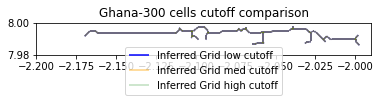

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch.plot(color = 'blue', label = 'Inferred Grid low cutoff')
lines_guess_gdf_stoch2.plot( ax = ax, color = 'orange', alpha = .5, label = 'Inferred Grid med cutoff')
lines_guess_gdf_stoch3.plot(ax = ax, color = 'green' , alpha = .25, label = 'Inferred Grid high cutoff')
#gh_line_df.plot(ax = ax, color = 'red', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.5) )
ax.set_title("Ghana-300 cells cutoff comparison")
ax.set_ylim(7.98, 8.0)
ax.set_xlim(-2.2, -1.99)

(-2.2, -1.99)

<Figure size 864x720 with 0 Axes>

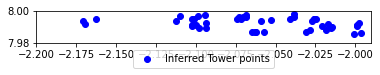

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = gh_twr_hits.plot( color = 'blue', label = 'Inferred Tower points')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -.5))
ax.set_ylim(7.98, 8.0)
ax.set_xlim(-2.2, -1.99)

## inference on GH ground truth

In [ ]:
dirs = ['ghana']
country_dict = { 'ghana':'GH'}
base_path = os.path.join('/content', 'drive', 'My Drive', 'PyPSA_Africa_images')
out_path = os.path.join(base_path, 'MAXAR_256')

for country in dirs:
    country_code = country_dict[country]
    max_ratio = 1.
    print(f"Making Examples for {country}!")

    # assess satellite imagery
    data_path = os.path.join(base_path, 'maxar', country, 'raw')

    #coverage_polygon = make_examples.make_polygon_list(data_path)
    lines_file = os.path.join(data_path, f"{country_code}_raw_lines.geojson")
    towers_file = os.path.join(data_path, f"{country_code}_raw_towers.geojson")

    gh_line_df = gpd.read_file(lines_file) # ground truth
    gh_twr_df = gpd.read_file(towers_file) # input into algo

Making Examples for ghana!


In [ ]:
gh_twr_df

In [ ]:
n_cells = 100
twr_df = gh_twr_df

network_guess_stoch, thinned_network_guess_stoch = network_inference_array_v2(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch = convert_guess_to_gdf_multilines(thinned_network_guess_stoch, twr_df, n_cells)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'